<a href="https://colab.research.google.com/github/omid-sar/Interview-Preparation/blob/main/ML_interview/tweet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

url = "https://raw.githubusercontent.com/omid-sar/Project_Data_Hub/main/twitter_toxic_final_balanced_dataset.csv"
response = requests.get(url)

if response.status_code == 200:
  with open("twitter_toxic.csv", "wb") as file:
    file.write(response.content)
  print("File downloaded and saved successfully")
else:
  print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and saved successfully


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("twitter_toxic.csv")
df = df.drop(columns=["Unnamed: 0"], axis=1)
df.head()

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


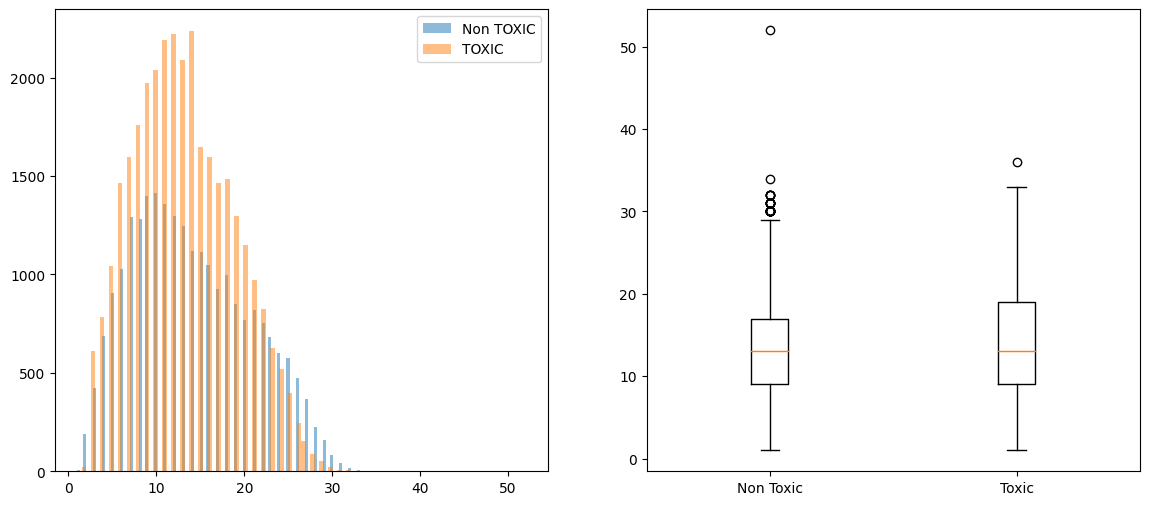

 
 
 Max Length: 52


In [3]:
import matplotlib.pyplot as plt

df["tweet_len"] = [len(seq.split()) for seq in df["tweet"]]
toxic_len = df[df["Toxicity"] == 0]["tweet_len"]
nontoxic_len = df[df["Toxicity"] == 1]["tweet_len"]

fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].hist(nontoxic_len, bins=100, alpha=0.5, label="Non TOXIC")
axes[0].hist(toxic_len, bins=100, alpha=0.5,  label="TOXIC")
axes[0].legend()

axes[1].boxplot([toxic_len, nontoxic_len], labels=["Non Toxic", "Toxic"])
plt.show()
print(f' \n \n Max Length: {max(df["tweet_len"])}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

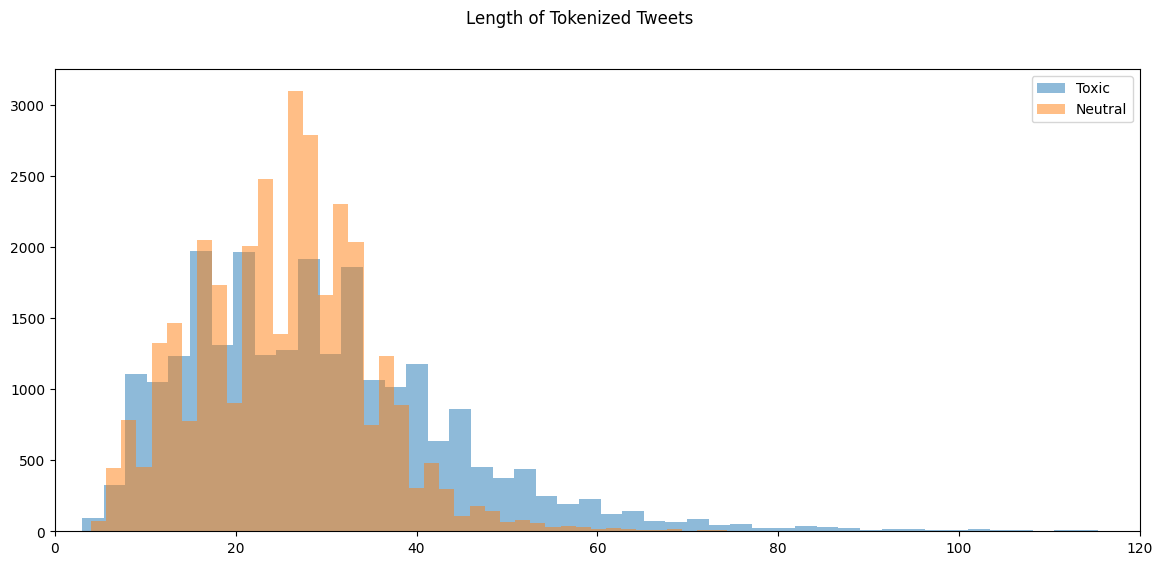

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df["tokenized_tweet_len"] = [len(tokenizer(seq).input_ids) for seq in df["tweet"]]
tokenized_toxic_len = df[df["Toxicity"]==1]["tokenized_tweet_len"]
tokenized_non_toxic_len = df[df["Toxicity"]==0]["tokenized_tweet_len"]

fig,ax = plt.subplots(figsize=(14,6))
ax.hist(tokenized_toxic_len, bins=200, alpha=0.5, label="Toxic")
ax.hist(tokenized_non_toxic_len, bins=200, alpha=0.5, label="Neutral")
fig.suptitle("Length of Tokenized Tweets")
ax.set_xlim([0, 120])
ax.legend()
plt.show()

In [5]:
import torch
MAX_LENGTH = 64

X = [seq for seq in df["tweet"]]
y = torch.tensor(df["Toxicity"])

model_inputs = tokenizer(X, padding=True, truncation=True, max_length=MAX_LENGTH , return_tensors="pt")

In [6]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    x = self.data[idx]
    y = self.labels[idx]
    return x, y


dataset = MyDataset(data=model_inputs.input_ids, labels=y)

In [7]:
from torch.utils.data import random_split, DataLoader

train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[train_size, val_size, test_size])


BATCH_SIZE = 32
NUM_WORKERS = 2
dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS)
next(iter(dataloader))

[tensor([[  101,  1030, 13504,  ...,     0,     0,     0],
         [  101,  3102,  2014,  ...,     0,     0,     0],
         [  101,  1030,  5310,  ...,     0,     0,     0],
         ...,
         [  101,  1030,  5310,  ...,     0,     0,     0],
         [  101,  1030, 10556,  ...,     0,     0,     0],
         [  101, 19387,  1030,  ...,     0,     0,     0]]),
 tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 1, 1])]

In [8]:
import torch.nn as nn


class MyLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim=64, lstm_hidden_size=128,lstm_num_layers=2, bidirectional=True,
               hidden_layers=[256,128], num_classes=2 ):
    super(MyLSTM, self).__init__()
    self.bidirectional = bidirectional
    self.lstm_num_layers = lstm_num_layers
    self.lstm_hidden_size = lstm_hidden_size
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden_size , num_layers=lstm_num_layers,
                        batch_first= True, bidirectional=bidirectional)
    fc_input_size = 2 * lstm_hidden_size if bidirectional else lstm_hidden_size
    self.fc1 = nn.Linear(fc_input_size, hidden_layers[0])
    self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
    self.fc3 = nn.Linear(hidden_layers[1], lstm_num_layers)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)

    h0 = torch.zeros((2 if self.bidirectional else 1) * self.lstm_num_layers,
                     x.size(0), self.lstm_hidden_size).to(device)
    c0 = torch.zeros((2 if self.bidirectional else 1) * self.lstm_num_layers,
                     x.size(0), self.lstm_hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = out[:, -1, :]

    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.sigmoid(self.fc3(out))
    return out


VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 64
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_LAYERs = 2
LSTM_BIDIRECTIONAL = True
HIDDEN_LAYERS = [256, 128]
model = MyLSTM(vocab_size=VOCAB_SIZE)
print(model)

MyLSTM(
  (embedding): Embedding(30522, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
  model.train()

  for batch_idx, (inputs, targets) in enumerate(dataloader):
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx %100 == 0:
      print(f"Epoch: [{epoch+1}/{NUM_EPOCHS}], Step: [{batch_idx}/{len(dataloader)}], Loss: [{loss.item():.4f}]")








Epoch: [1/10], Step: [0/1242], Loss: [0.6924]
Epoch: [1/10], Step: [100/1242], Loss: [0.6542]
Epoch: [1/10], Step: [200/1242], Loss: [0.6948]
Epoch: [1/10], Step: [300/1242], Loss: [0.7156]
Epoch: [1/10], Step: [400/1242], Loss: [0.6309]
Epoch: [1/10], Step: [500/1242], Loss: [0.6848]
Epoch: [1/10], Step: [600/1242], Loss: [0.5044]
Epoch: [1/10], Step: [700/1242], Loss: [0.6042]
Epoch: [1/10], Step: [800/1242], Loss: [0.6022]
Epoch: [1/10], Step: [900/1242], Loss: [0.6912]
Epoch: [1/10], Step: [1000/1242], Loss: [0.6334]
Epoch: [1/10], Step: [1100/1242], Loss: [0.6452]
Epoch: [1/10], Step: [1200/1242], Loss: [0.6746]
Epoch: [2/10], Step: [0/1242], Loss: [0.6058]
Epoch: [2/10], Step: [100/1242], Loss: [0.6271]
Epoch: [2/10], Step: [200/1242], Loss: [0.5549]
Epoch: [2/10], Step: [300/1242], Loss: [0.6141]
Epoch: [2/10], Step: [400/1242], Loss: [0.5097]
Epoch: [2/10], Step: [500/1242], Loss: [0.5122]
Epoch: [2/10], Step: [600/1242], Loss: [0.4717]
Epoch: [2/10], Step: [700/1242], Loss: [0